<a href="https://colab.research.google.com/github/YanzhaoZ/PreBit/blob/main/Price_Base_Model_New_Input.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#set-ups 

In [ ]:
 !pip install yfinance
import yfinance as yf
import pandas as pd


     |████████████████████████████████| 5.5MB 19.6MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=28c0e73ea9ca32f32e526657e8fca4a3bb09626701591c8cae15e42d87cd45be
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset, WeightedRandomSampler
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
import time
import numpy as np

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Loading Price Data

In [ ]:
start_date ='2015-01-01'
end_date = '2019-12-31'
price = yf.download("BTC-USD", start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed


In [ ]:
def get_technical_indicators(price):
    # Create 7 and 21 days Moving Average
    dataset = price.copy()

    dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window=21).mean()
    
    # Create MACD
    #dataset['26ema'] = pd.ewma(dataset['Close'], span=26)
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    #dataset['12ema'] = pd.ewma(dataset['Close'], span=12)
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    #dataset['20sd'] = pd.stats.moments.rolling_std(dataset['Close'],20)
    dataset['20sd'] = dataset["Close"].rolling(window=20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    # Create Momentum
    #dataset['momentum'] = dataset['Close']-1

    # Create high-low spred
    dataset['spread'] = dataset['High'] - dataset['Low']
    
    return dataset

The Gold etf SPDR Gold future, has a lot of NAN values. 
That might cause some issues, but let's see how it goes first.

In [ ]:
 # to be finished 
# def get_related_asset (price, start_date, end_date):
#     other_price = yf.download("ETH-USD", start=start_date, end=end_date)

#     price['eth']=other_price["Close"]
#     #there are nan values because the price datarange is not the same. so I should probalby fill the value by non-0, coz i need to do division later...
#     #let's fill it with the next valid value 
#     price.eth.fillna(method='bfill', inplace= True, axis=0)

#     return price

 # to be finished 
def get_related_asset (price, start_date, end_date):
    other_price = yf.download("ETH-USD GLD", start=start_date, end=end_date)

    price['eth']=other_price.Close['ETH-USD']
    price['gold'] = other_price.Close['GLD']
    #there are nan values because the price datarange is not the same. so I should probalby fill the value by non-0, coz i need to do division later...
    #let's fill it with the next valid value 
    price.eth.fillna(method='bfill', inplace= True, axis=0)
    price.gold.fillna(method='bfill', inplace= True, axis=0) 

    return price


In [ ]:
def get_label (price,threshold):


    price['change']=price.shift(-1).High/price.Close -1 
    price['change_label']=price['change'].apply (lambda x: x> threshold)

    #convert True/False to 1/0
    class2idx = {True: 1, False:0}
    price['change_label'].replace(class2idx, inplace=True)

    return price

In [ ]:
def normalise_close(price):
    
    df = price.copy()
    for key in df.keys():
        if not key in ['change','change_label','Volume','MACD','20sd','spread','eth','gold']:
            df[key]=df[key]/price['Close'].shift(1) - 1
        
    df['Volume']=df['Volume']/price['Volume'].shift(1)-1
    df['eth']  = df['eth']/price['eth'].shift(1)-1
    df['gold'] = df['gold']/price['gold'].shift(1)-1
    df['MACD'] = df['MACD']/price['Close'].shift(1)
    df['20sd'] = df['20sd']/price['Close'].shift(1)
    df['spread'] = df['spread']/price['Close'].shift(1)



    return df


In [ ]:
def get_ma_feature (price,threshold):
    price['ma_feature']=price['ma7'].apply(lambda x: x > threshold)
    
    class2idx = {True: 1, False:0}
    price['ma_feature'].replace(class2idx, inplace=True)
    return price

In [ ]:
#Here I want to define a function to return a new dataframe, that's INDEPENDANT, and produce relative price. 
def process_price (original_df,threshold, start_date,end_date):
    #get the indicators
    df = get_technical_indicators(original_df)

    #get related asset
    df = get_related_asset(df,start_date,end_date)

    #get label
    df = get_label(df, threshold)

    #normalise the data
    df_normalised_close = normalise_close(df)

    #get ma label
    df_normalised_close = get_ma_feature(df_normalised_close, threshold)

    #return both normalized, and un-normalized data (w/o ma label). 
    return df, df_normalised_close





In [ ]:
test_df, test_df_norm = process_price(price,0.05,start_date,end_date)

[*********************100%***********************]  2 of 2 completed


In [ ]:
test_df.head()

,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,spread,eth,gold,change,change_label
Date,,,,,,,,,,,,,,,,,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550,NaN,NaN,314.248993,314.248993,0.000000,NaN,NaN,NaN,314.248993,6.432007,2.77212,114.080002,0.005060,0
2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650,NaN,NaN,314.655561,314.673129,0.017568,NaN,NaN,NaN,314.836258,2.273987,2.77212,114.080002,0.000375,0
2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400,NaN,NaN,302.592907,301.562504,-1.030403,NaN,NaN,NaN,291.467926,34.067993,2.77212,115.800003,0.021873,0
2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100,NaN,NaN,291.858532,289.767045,-2.091487,NaN,NaN,NaN,273.058706,29.618011,2.77212,115.800003,0.053544,1
2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800,NaN,NaN,287.826987,285.611979,-2.215008,NaN,NaN,NaN,274.006134,13.256989,2.77212,115.800003,0.047651,0


In [ ]:
test_df_norm.head()

,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,spread,eth,gold,change,change_label,ma_feature
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005060,0,0
2015-01-02,-0.000541,0.005060,-0.002177,0.002492,0.002492,-0.021888,NaN,NaN,0.001294,0.001350,0.000056,NaN,NaN,NaN,0.001869,0.007236,0.0,0.000000,0.000375,0,0
2015-01-03,-0.000590,0.000375,-0.107767,-0.107767,-0.107767,3.205047,NaN,NaN,-0.039485,-0.042756,-0.003271,NaN,NaN,NaN,-0.074799,0.108141,0.0,0.015077,0.021873,0,0
2015-01-04,0.000228,0.021873,-0.083499,-0.060079,-0.060079,0.682956,NaN,NaN,0.038339,0.030899,-0.007441,NaN,NaN,NaN,-0.028544,0.105371,0.0,0.000000,0.053544,1,0
2015-01-05,0.003365,0.053544,0.003365,0.038907,0.038907,-0.209716,NaN,NaN,0.089449,0.081065,-0.008384,NaN,NaN,NaN,0.037136,0.050179,0.0,0.000000,0.047651,0,0


In [ ]:
test_df_norm.change_label.value_counts()

0    1608
1     218
Name: change_label, dtype: int64

# Some analysis with MA only

In [ ]:
(test_df_norm['change_label']==test_df_norm['ma_feature']).value_counts()

True     1537
False     289
dtype: int64

In [ ]:
test_df_norm['change_label'].value_counts()

0    1608
1     218
Name: change_label, dtype: int64

In [ ]:
#7day ma feature

#why not get a confusion matrix with these two labels and check it out. 
accuracy = (test_df_norm['change_label']==test_df_norm['ma_feature']).sum() / len(test_df_norm['change_label']==test_df_norm['ma_feature'])
print ('accuracy:', accuracy)
print (confusion_matrix(test_df_norm['change_label'].values, test_df_norm['ma_feature'].values))
print (classification_report(test_df_norm['change_label'].values, test_df_norm['ma_feature'].values))

#The true label, accuracy is only 0.27, and recall rate is quite low to be honest. 

accuracy: 0.8417305585980285
[[1495  113]
 [ 176   42]]
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1608
           1       0.27      0.19      0.23       218

    accuracy                           0.84      1826
   macro avg       0.58      0.56      0.57      1826
weighted avg       0.82      0.84      0.83      1826



In [ ]:
#for 21day ma features

#why not get a confusion matrix with these two labels and check it out. 
accuracy = (test_df_norm['change_label']==test_df_norm['ma_feature']).sum() / len(test_df_norm['change_label']==test_df_norm['ma_feature'])
print ('accuracy:', accuracy)
print (confusion_matrix(test_df_norm['change_label'].values, test_df_norm['ma_feature'].values))
print (classification_report(test_df_norm['change_label'].values, test_df_norm['ma_feature'].values))

#The true label, accuracy is only 0.15, but recall is higher. 

accuracy: 0.7431544359255202
[[1301  307]
 [ 162   56]]
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      1608
           1       0.15      0.26      0.19       218

    accuracy                           0.74      1826
   macro avg       0.52      0.53      0.52      1826
weighted avg       0.80      0.74      0.77      1826



In [ ]:
#for ema features

#why not get a confusion matrix with these two labels and check it out. 
accuracy = (test_df_norm['change_label']==test_df_norm['ma_feature']).sum() / len(test_df_norm['change_label']==test_df_norm['ma_feature'])
print ('accuracy:', accuracy)
print (confusion_matrix(test_df_norm['change_label'].values, test_df_norm['ma_feature'].values))
print (classification_report(test_df_norm['change_label'].values, test_df_norm['ma_feature'].values))

#The true label, accuracy is only 0.27, and recall rate is quite low to be honest. 

accuracy: 0.864184008762322
[[1561   47]
 [ 201   17]]
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1608
           1       0.27      0.08      0.12       218

    accuracy                           0.86      1826
   macro avg       0.58      0.52      0.52      1826
weighted avg       0.81      0.86      0.83      1826



In [ ]:
#so bascially 7day ma works best among these 3. got it. 


# Format Custom Dataset input for Torch Models

Creating two dataset classes for future use, 1 is for classification tast, the other for Regression task

In [ ]:
class ClassifierDataset(Dataset):
    def __init__(self,df):
        self.df = df
        self.X, self.Y = self.clean_df()


    def __len__(self):
        return len(self.Y)


    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


    def clean_df(self):
        #drop NaN values, and also load the values into torch.tensor. 
        df = self.df.dropna()
        y_values = df.change_label.values
        df = df.drop (['change','change_label'],axis=1)
        #try put the label as part of the feature see if the model cna leran that 
        #df = df.drop (['change'],axis=1)
        x_values = df.values

        return torch.from_numpy(x_values).float(), torch.from_numpy(y_values).long()


      


In [ ]:
class RegressionDataset(Dataset):
    def __init__(self,df):
        self.df = df
        self.X, self.Y = self.clean_df()


    def __len__(self):
        return len(self.Y)


    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


    def clean_df(self):
        #drop NaN values, and also load the values into torch.tensor.
        df = self.df.dropna()
        y_values = df.change.values
        df = df.drop (['change','change_label'],axis=1)
        x_values = df.values

        return torch.from_numpy(x_values).float(), torch.from_numpy(y_values).float()



In [ ]:
# define a function for train_test split, and initiate dataset? 
def split_train_test (df, threshold):
    length = len(df)
    split_number  = round(threshold*length)
    return df[0:split_number], df[split_number:]

In [ ]:
#for classification dataset construction
test_df_train,test_df_eval = split_train_test(test_df_norm, 0.7)
train_dataset = ClassifierDataset(test_df_train)
eval_dataset = ClassifierDataset (test_df_eval)

In [ ]:
# for Regression dataset construction

# test_df_train,test_df_eval = split_train_test(test_df_norm, 0.7)
# train_dataset = RegressionDataset(test_df_train)
# eval_dataset = RegressionDataset (test_df_eval)

In [ ]:
eval_dataset[0]

(tensor([-0.0009,  0.0467, -0.0125,  0.0358,  0.0358, -0.0817, -0.0207,  0.0035,
          0.0373, -0.0022, -0.0395,  0.0413,  0.0861, -0.0791,  0.0226,  0.0592,
          0.0472,  0.0000,  0.0000]), tensor(0))

# Format DataLoader, different sampling options

In [ ]:
#Now let's try to flow the data into dataloader 
train_loader = DataLoader(train_dataset, batch_size = 64, )
eval_loader = DataLoader(eval_dataset, batch_size = 64, )
# add in shuffle/sampler options later

The above is the normal dataloader. Below I will try to use weighted samplers, which will include oversample and undersamples, and in this case, it will also disrupt the ordering/sequence of the input, ummmmmmmmmmm, How will that affect the model performance, let's seeeeeeeee

In [ ]:
#obtain the label list. 
target_list = []
for _,t in train_dataset:
  target_list.append(t)




In [ ]:
#obtain the class weights
leng = len(target_list)
total_true = sum(target_list)
class_count = [leng-total_true, total_true]
class_weight = 1./torch.tensor(class_count, dtype=torch.float)
class_weight

tensor([0.0009, 0.0062])

In [ ]:
#a weight for each sample
class_weights_all = class_weight[target_list]

In [ ]:
weighted_sampler = WeightedRandomSampler(
    weights = class_weights_all,
    num_samples = leng,
    replacement = True
)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = 64, sampler=weighted_sampler )
eval_loader = DataLoader(eval_dataset, batch_size = 64, )
# add in shuffle/sampler options later

In [ ]:
for i, batch in enumerate(train_loader):
    _,t = (m for m in batch)
    print (sum(t)/len(t))

tensor(0.5312)
tensor(0.5625)
tensor(0.4688)
tensor(0.5938)
tensor(0.4844)
tensor(0.3906)
tensor(0.4844)
tensor(0.4844)
tensor(0.4062)
tensor(0.5312)
tensor(0.4375)
tensor(0.5781)
tensor(0.5000)
tensor(0.3906)
tensor(0.5000)
tensor(0.5625)
tensor(0.5000)
tensor(0.7031)
tensor(0.3594)
tensor(0.5238)


In [ ]:
#next(iter(train_loader))

In [ ]:
# for i, batch in enumerate(train_loader):
#     print (i)

In [ ]:
#weighed random sampler test. 

# import torch
# from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, TensorDataset
# train_dataset = torch.tensor([1, 1 , 1, 1, 1, 1, 1, 1, 1, 0])


# class_weights_all = [0.1, 0.1, 0.1, 0.1,0.1, 0.1, 0.1, 0.1,0.1, 0.9]

# weighted_sampler = WeightedRandomSampler(
#     weights=class_weights_all,
#     num_samples=10,
#     replacement=True #if True, sampler will draw repeating inputs, False will have 0 repeats. 
# )

# BATCH_SIZE = 5
# dataset = TensorDataset(train_dataset)
# train_loader = DataLoader(dataset,
#                           batch_size=BATCH_SIZE,
#                           sampler=weighted_sampler
# )
# for batch in train_loader:
#     print(batch)

#Format Dataset and DataLoader for LSTM

In [ ]:
class LSTMDataset(Dataset):
    def __init__(self,df,window_size):
        self.df = df
        self.window_size = window_size
        self.X, self.Y = self.clean_df()


    def __len__(self):
        return len(self.Y)


    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


    def clean_df(self):
        #drop NaN values, and also load the values into torch.tensor. 
        df = self.df.dropna()
        y_values = df.change_label.values[self.window_size:]
        df = df.drop (['change','change_label'],axis=1)
        #try put the label as part of the feature see if the model cna leran that 
        #df = df.drop (['change'],axis=1)
        x_values = df.values
        output = self.process(x_values)


        return torch.tensor(output,dtype=torch.float), torch.from_numpy(y_values).long()

    def process(self,data):
        output = []
        for i in range(self.window_size-1, len(data)):
            raw_data = data[i-self.window_size+1:i+1]
            output.append(raw_data)
        return output



In [ ]:
# define a function for train_test split, and initiate dataset? 
def split_train_test (df, threshold):
    length = len(df)
    split_number  = round(threshold*length)
    return df[0:split_number], df[split_number:]

In [ ]:
#for classification dataset construction
test_df_train,test_df_eval = split_train_test(test_df_norm, 0.7)
WINDOW_SIZE = 10 
train_dataset = LSTMDataset(test_df_train, window_size=WINDOW_SIZE)
eval_dataset = LSTMDataset (test_df_eval, window_size= WINDOW_SIZE)

In [ ]:
train_dataset[0]

(tensor([[ 2.9815e-04,  7.7955e-02, -4.8741e-04,  7.3738e-02,  7.3738e-02,
           2.4421e-01,  9.5185e-04,  1.9347e-01,  1.2295e-01,  6.5804e-02,
          -5.7147e-02,  1.8713e-01,  5.6772e-01, -1.8079e-01,  4.9743e-02,
           7.8442e-02,  0.0000e+00,  2.4160e-04,  0.0000e+00],
         [ 1.8731e-03,  4.4611e-02, -2.0406e-03,  2.8687e-02,  2.8687e-02,
           1.2097e-01, -5.2953e-02,  9.4539e-02,  4.4277e-02, -1.6947e-03,
          -4.5971e-02,  1.6074e-01,  4.1603e-01, -2.2695e-01,  1.1676e-02,
           4.6651e-02,  0.0000e+00,  8.0496e-03,  0.0000e+00],
         [ 4.7553e-04,  6.1652e-03, -3.5175e-02, -2.2579e-03, -2.2579e-03,
          -2.6600e-01, -6.4195e-02,  4.7255e-02,  1.3600e-02, -2.5246e-02,
          -3.8846e-02,  1.5229e-01,  3.5183e-01, -2.5732e-01, -7.0176e-03,
           4.1340e-02,  0.0000e+00, -7.9853e-03,  0.0000e+00],
         [-7.6864e-04,  6.5833e-02, -1.2268e-02,  6.4274e-02,  6.4274e-02,
           6.5308e-03, -3.2272e-02,  4.2829e-02,  2.0149e-02,

In [ ]:
#a vanilla dataloader

train_loader = DataLoader(train_dataset, batch_size = 64, )
eval_loader = DataLoader(eval_dataset, batch_size = 64, )


In [ ]:
#weighted_dataloader

#obtain the label list. 
target_list = []
for _,t in train_dataset:
  target_list.append(t)

#obtain the class weights
leng = len(target_list)
total_true = sum(target_list)
class_count = [leng-total_true, total_true]
class_weight = 1./torch.tensor(class_count, dtype=torch.float)


#a weight for each sample
class_weights_all = class_weight[target_list]

weighted_sampler = WeightedRandomSampler(
    weights = class_weights_all,
    num_samples = leng,
    replacement = True
)

In [ ]:
#train_loader = DataLoader(train_dataset, batch_size = 64, sampler=weighted_sampler )
train_loader = DataLoader(train_dataset, batch_size = 64, )
eval_loader = DataLoader(eval_dataset, batch_size = 64, )
# add in shuffle/sampler options later

In [ ]:
next(iter(train_loader))

[tensor([[[ 2.9815e-04,  7.7955e-02, -4.8741e-04,  ...,  0.0000e+00,
            2.4160e-04,  0.0000e+00],
          [ 1.8731e-03,  4.4611e-02, -2.0406e-03,  ...,  0.0000e+00,
            8.0496e-03,  0.0000e+00],
          [ 4.7553e-04,  6.1652e-03, -3.5175e-02,  ...,  0.0000e+00,
           -7.9853e-03,  0.0000e+00],
          ...,
          [-4.7061e-04,  1.1614e-02, -1.3826e-01,  ...,  0.0000e+00,
           -7.8778e-03,  0.0000e+00],
          [-2.4239e-03,  2.0482e-02, -5.6444e-02,  ...,  0.0000e+00,
           -2.1552e-02,  1.0000e+00],
          [-3.1733e-03,  3.9989e-02, -3.2863e-02,  ...,  0.0000e+00,
            2.2276e-02,  1.0000e+00]],
 
         [[ 1.8731e-03,  4.4611e-02, -2.0406e-03,  ...,  0.0000e+00,
            8.0496e-03,  0.0000e+00],
          [ 4.7553e-04,  6.1652e-03, -3.5175e-02,  ...,  0.0000e+00,
           -7.9853e-03,  0.0000e+00],
          [-7.6864e-04,  6.5833e-02, -1.2268e-02,  ...,  0.0000e+00,
           -9.9815e-03,  0.0000e+00],
          ...,
    



# Torch Model 1 - FeedForward Classification

In [ ]:
#let's first try a simple FC NN
class FFNN (nn.Module):
    def __init__(self, input_size, num_classes,num_hidden, hidden_dim ):
        super().__init__()

        assert num_hidden > 0 

        self.fc1 = nn.Linear(input_size,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim)

        self.hidden_layers = nn.ModuleList([])
        self.hidden_layers.append (self.fc1)
        for i in range (num_hidden -1 ):
            self.hidden_layers.append(self.fc2)
        
        self.final_layer = nn.Linear (hidden_dim,num_classes)
        self.dropout = nn.Dropout()
        self.relu = nn.ReLU()

    def forward(self,x):
        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
            x = self.dropout(x)
            x = self.relu(x)
        
        out = self.final_layer(x)
        out_dist = F.log_softmax(out, dim= -1) #why is it -1, ok, coz it's batch x input x class. 

        return out_dist



In [ ]:
#try initiating the model
INPUT_SIZE = 19
NUM_CLASSES = 2
NUM_HIDDEN = 2
HIDDEN_DIM = 512

model = FFNN(INPUT_SIZE, NUM_CLASSES, NUM_HIDDEN, HIDDEN_DIM)


In [ ]:
model

FFNN(
  (fc1): Linear(in_features=19, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=19, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
  )
  (final_layer): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

In [ ]:
#print model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 273,922 trainable parameters


In [ ]:
#define loss fuction and optimizer
optimizer = optim.Adam(model.parameters())
loss_fn = nn.NLLLoss()


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = loss_fn.to(device)

In [ ]:
#define a function to calcualte prediction accuracy
def accuracy(pred,label):
    _,pred_label = torch.max(pred,dim=1)
    correct = (pred_label==label).float()
    accuracy = correct.sum()/len(correct)
    return accuracy

In [ ]:
#can i define a function to calculate the f1 score/confusion matrix? 
def get_cfm (pred, label):
    _,pred_label = torch.max(pred,dim=1)
    m = classification_report(pred_label.cpu(), label.cpu())
    return m


In [ ]:
#now define the training and evaluation loop
def train(model, dataloader, optimizer, loss_fn):
    model.train()

    epoch_loss= 0
    epoch_acc = 0

    for step,batch in enumerate(dataloader):
        optimizer.zero_grad()

        data, label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred,label)
        acc  = accuracy(pred,label)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc

    return epoch_loss/len(dataloader), epoch_acc/len(dataloader)
        



In [ ]:
def evaluate(model,dataloader,loss_fn):
    model.eval()

    epoch_loss = 0 
    epoch_acc = 0 

    pred_list =[]
    label_list =[]
    for step,batch in enumerate(dataloader):
        data,label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred,label)
        acc = accuracy(pred,label)
        
        #append the prediction result and show it per epoch later. 
        if step ==0:     
            pred_list=pred.cpu().detach().numpy()
            label_list = label.cpu().detach().numpy()
        if step != 0:
            pred_list = np.concatenate([pred_list,pred.cpu().detach().numpy()],axis =0)
            label_list = np.concatenate([label_list,label.cpu().detach().numpy()],axis =0)

        epoch_loss += loss.item()
        epoch_acc += acc

    report = get_cfm(torch.tensor(pred_list),torch.tensor(label_list))
    print (report)
    return epoch_loss/len(dataloader), epoch_acc/len(dataloader)
        

In [ ]:
N_EPOCHS = 5

for i in range(N_EPOCHS):
    train_loss,train_acc = train(model,train_loader, optimizer, loss_fn)
    
    eval_loss, eval_acc = evaluate(model,eval_loader, loss_fn)
    
    print (f' Epoch Number {i}') 
    print (f' Train. Loss: {train_loss:.3f} Train. Acc: {train_acc*100:.2f}%')
    print (f' Eval loss , {eval_loss:.3f}, eval acc, {eval_acc*100:.2f} %')
    # print(f'\t Train. Loss: {train_loss:.3f} |  Train. Acc: {train_acc*100:.2f}%')
    # print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

              precision    recall  f1-score   support

           0       0.89      0.92      0.91       480
           1       0.25      0.19      0.22        67

    accuracy                           0.83       547
   macro avg       0.57      0.56      0.56       547
weighted avg       0.81      0.83      0.82       547

 Epoch Number 0
 Train. Loss: 0.678 Train. Acc: 55.99%
 Eval loss , 0.589, eval acc, 83.45 %
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       478
           1       0.29      0.22      0.25        69

    accuracy                           0.84       547
   macro avg       0.59      0.57      0.58       547
weighted avg       0.82      0.84      0.82       547

 Epoch Number 1
 Train. Loss: 0.618 Train. Acc: 67.00%
 Eval loss , 0.471, eval acc, 83.80 %
              precision    recall  f1-score   support

           0       0.83      0.92      0.88       448
           1       0.33      0.17      0.23        

In [ ]:
# #obtain the label list. 
# target_list = []
# for _,t in eval_dataset:
#   target_list.append(t)

# #obtain the class weights
# leng = len(target_list)
# total_true = sum(target_list)
# class_count = [leng-total_true, total_true]
# class_count

In [ ]:
# for step,batch in enumerate(eval_loader):

#     data,label = (t for t in batch)
#     data = data.to(device)
#     label = label.to(device)

#     pred = model(data)
#     loss = loss_fn(pred,label)
#     acc = accuracy(pred,label)
#     report = get_cfm(pred,label)
    
#     epoch_loss += loss.item()
#     epoch_acc += acc     

        

In [ ]:
    # pred_list =[]
    # label_list =[]
    # for step,batch in enumerate(eval_loader):
    #     data,label = (t for t in batch)
    #     data = data.to(device)
    #     label = label.to(device)

    #     pred = model(data)
    #     loss = loss_fn(pred,label)
    #     acc = accuracy(pred,label)
    #     if step ==0:
    #         pred_list=pred.cpu().detach().numpy()
    #         label_list = label.cpu().detach().numpy()
    #     if step != 0:
    #         pred_list = np.concatenate([pred_list,pred.cpu().detach().numpy()],axis =0)
    #         label_list = np.concatenate([label_list,label.cpu().detach().numpy()],axis =0)



    # report = get_cfm(torch.tensor(pred_list),torch.tensor(label_list))
    # print (report)


In [ ]:
target = torch.empty(3).random_(2)
target

tensor([0., 0., 1.])

# Torch Model 1.1 - FeedForward with CE

In [ ]:
#let's first try a simple FC NN
class FFNN (nn.Module):
    def __init__(self, input_size, num_classes,num_hidden, hidden_dim ):
        super().__init__()

        assert num_hidden > 0 

        self.fc1 = nn.Linear(input_size,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim)

        self.hidden_layers = nn.ModuleList([])
        self.hidden_layers.append (self.fc1)
        for i in range (num_hidden -1 ):
            self.hidden_layers.append(self.fc2)
        
        self.final_layer = nn.Linear (hidden_dim,num_classes)
        self.dropout = nn.Dropout()
        self.relu = nn.ReLU()

    def forward(self,x):
        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
            x = self.dropout(x)
            x = self.relu(x)
        
        out = self.final_layer(x)
         #why is it -1, ok, coz it's batch x input x class. 

        return out


In [ ]:
#try initiating the model
INPUT_SIZE = 19
NUM_CLASSES = 2
NUM_HIDDEN = 2
HIDDEN_DIM = 512

model = FFNN(INPUT_SIZE, NUM_CLASSES, NUM_HIDDEN, HIDDEN_DIM)


In [ ]:
#define loss fuction and optimizer
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = loss_fn.to(device)

In [ ]:
#now define the training and evaluation loop
def train(model, dataloader, optimizer, loss_fn):
    model.train()

    epoch_loss= 0
    epoch_acc = 0

    for step,batch in enumerate(dataloader):
        optimizer.zero_grad()

        data, label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred,label)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss/len(dataloader)
        



In [ ]:
def evaluate(model,dataloader,loss_fn):
    model.eval()

    epoch_loss = 0 
    epoch_acc = 0 

    pred_list =[]
    label_list =[]
    for step,batch in enumerate(dataloader):
        data,label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred,label)
        

        epoch_loss += loss.item()


    return epoch_loss/len(dataloader)

In [ ]:
N_EPOCHS = 10

for i in range(N_EPOCHS):
    train_loss = train(model,train_loader, optimizer, loss_fn)
    
    eval_loss = evaluate(model,eval_loader, loss_fn)
    
    print (f' Epoch Number {i}') 
    print (f' Train. Loss: {train_loss:.3f} ')
    print (f' Eval loss , {eval_loss:.3f} ')
    # print(f'\t Train. Loss: {train_loss:.3f} |  Train. Acc: {train_acc*100:.2f}%')
    # print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

 Epoch Number 0
 Train. Loss: 0.664 
 Eval loss , 0.591 
 Epoch Number 1
 Train. Loss: 0.622 
 Eval loss , 0.504 
 Epoch Number 2
 Train. Loss: 0.617 
 Eval loss , 0.569 
 Epoch Number 3
 Train. Loss: 0.579 
 Eval loss , 0.488 
 Epoch Number 4
 Train. Loss: 0.601 
 Eval loss , 0.527 
 Epoch Number 5
 Train. Loss: 0.573 
 Eval loss , 0.472 
 Epoch Number 6
 Train. Loss: 0.603 
 Eval loss , 0.544 
 Epoch Number 7
 Train. Loss: 0.581 
 Eval loss , 0.543 
 Epoch Number 8
 Train. Loss: 0.602 
 Eval loss , 0.536 
 Epoch Number 9
 Train. Loss: 0.585 
 Eval loss , 0.487 


# Torch Model 2 - Feedforward Classification with F1 loss function

In [ ]:
#let's first try a simple FC NN
class FFNN_F1 (nn.Module):
    def __init__(self, input_size, num_classes,num_hidden, hidden_dim ):
        super().__init__()

        assert num_hidden > 0 

        self.fc1 = nn.Linear(input_size,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim)

        self.hidden_layers = nn.ModuleList([])
        self.hidden_layers.append (self.fc1)
        for i in range (num_hidden -1 ):
            self.hidden_layers.append(self.fc2)
        
        self.final_layer = nn.Linear (hidden_dim,num_classes)
        self.dropout = nn.Dropout()
        self.relu = nn.ReLU()

    def forward(self,x):
        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
            x = self.dropout(x)
            x = self.relu(x)
        
        out = self.final_layer(x)
               
        return out


In [ ]:
#try initiating the model
INPUT_SIZE = 19
NUM_CLASSES = 2
NUM_HIDDEN = 2
HIDDEN_DIM = 512

model = FFNN_F1(INPUT_SIZE, NUM_CLASSES, NUM_HIDDEN, HIDDEN_DIM)

model


FFNN_F1(
  (fc1): Linear(in_features=19, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=19, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
  )
  (final_layer): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

In [ ]:
#print model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 273,922 trainable parameters


In [ ]:
#define optimizer, loss function
class F1_Loss(nn.Module):
    '''Calculate F1 score. Can work with gpu tensors
    
    The original implmentation is written by Michal Haltuf on Kaggle.
    
    Returns
    -------
    torch.Tensor
        `ndim` == 1. epsilon <= val <= 1
    
    Reference
    ---------
    - https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
    - https://discuss.pytorch.org/t/calculating-precision-recall-and-f1-score-in-case-of-multi-label-classification/28265/6
    - http://www.ryanzhang.info/python/writing-your-own-loss-function-module-for-pytorch/
    '''
    def __init__(self, epsilon=1e-7):
        super().__init__()
        self.epsilon = epsilon
        
    def forward(self, y_pred, y_true,):
        assert y_pred.ndim == 2
        assert y_true.ndim == 1
        y_true = F.one_hot(y_true, 2).to(torch.float32)
        y_pred = F.softmax(y_pred, dim=1)
        
        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2* (precision*recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1-self.epsilon)
        return 1 - f1.mean()


params = model.parameters()
optimizer = optim.Adam(params)
loss_fn =F1_Loss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = loss_fn.to(device)

print (device)

cuda


In [ ]:
def accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    prediciton = F.softmax(preds, dim =1)
    _, pred = torch.max(prediciton, 1)
    correct = (pred == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
#can i define a function to calculate the f1 score/confusion matrix? 
def get_cfm (preds, label):
    pred = F.softmax(preds, dim =1)
    _,pred_label = torch.max(pred,dim=1)
    m = classification_report(pred_label.cpu(), label.cpu())
    return m

In [ ]:
#now define the training and evaluation loop
def train(model, dataloader, optimizer, loss_fn):
    model.train()

    epoch_loss= 0
    epoch_acc = 0

    for step,batch in enumerate(dataloader):
        optimizer.zero_grad()

        data, label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred,label)
        acc  = accuracy(pred,label)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc

    return epoch_loss/len(dataloader), epoch_acc/len(dataloader)

In [ ]:
def evaluate(model,dataloader,loss_fn):
    model.eval()

    epoch_loss = 0 
    epoch_acc = 0 

    pred_list =[]
    label_list =[]
    for step,batch in enumerate(dataloader):
        data,label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred,label)
        acc = accuracy(pred,label)
        
        #append the prediction result and show it per epoch later. 
        if step ==0:     
            pred_list=pred.cpu().detach().numpy()
            label_list = label.cpu().detach().numpy()
        if step != 0:
            pred_list = np.concatenate([pred_list,pred.cpu().detach().numpy()],axis =0)
            label_list = np.concatenate([label_list,label.cpu().detach().numpy()],axis =0)

        epoch_loss += loss.item()
        epoch_acc += acc

    report = get_cfm(torch.tensor(pred_list),torch.tensor(label_list))
    print (report)
    return epoch_loss/len(dataloader), epoch_acc/len(dataloader)
        

In [ ]:
N_EPOCHS = 10

for i in range(N_EPOCHS):
    train_loss,train_acc = train(model,train_loader, optimizer, loss_fn)
    
    eval_loss, eval_acc = evaluate(model,eval_loader, loss_fn)
    
    print (f' Epoch Number {i}') 
    print (f' Train. Loss: {train_loss:.3f} Train. Acc: {train_acc*100:.2f}%')
    print (f' Eval loss , {eval_loss:.3f}, eval acc, {eval_acc*100:.2f} %')
    # print(f'\t Train. Loss: {train_loss:.3f} |  Train. Acc: {train_acc*100:.2f}%')
    # print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       474
           1       0.27      0.19      0.23        73

    accuracy                           0.82       547
   macro avg       0.58      0.56      0.56       547
weighted avg       0.80      0.82      0.81       547

 Epoch Number 0
 Train. Loss: 0.481 Train. Acc: 57.39%
 Eval loss , 0.571, eval acc, 82.76 %
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       444
           1       0.39      0.19      0.26       103

    accuracy                           0.79       547
   macro avg       0.61      0.56      0.57       547
weighted avg       0.75      0.79      0.76       547

 Epoch Number 1
 Train. Loss: 0.427 Train. Acc: 62.00%
 Eval loss , 0.521, eval acc, 79.63 %
              precision    recall  f1-score   support

           0       0.73      0.94      0.82       383
           1       0.55      0.17      0.26       1

# Torch Model 3 - Feedforward Regresssion

In [ ]:
#let's first try a simple FC NN
class FFNN_regression (nn.Module):
    def __init__(self, input_size,num_hidden, hidden_dim ):
        super().__init__()

        assert num_hidden > 0 

        self.fc1 = nn.Linear(input_size,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim)

        self.hidden_layers = nn.ModuleList([])
        self.hidden_layers.append (self.fc1)
        for i in range (num_hidden -1 ):
            self.hidden_layers.append(self.fc2)
        
        self.final_layer = nn.Linear (hidden_dim,1)
        self.dropout = nn.Dropout()
        self.relu = nn.ReLU()

    def forward(self,x):
        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
            x = self.dropout(x)
            x = self.relu(x)
        
        out = self.final_layer(x)
        
        return out



In [ ]:
#try initiating the model
INPUT_SIZE = 18
NUM_HIDDEN = 4
HIDDEN_DIM = 1024

model = FFNN_regression(INPUT_SIZE, NUM_HIDDEN, HIDDEN_DIM)


In [ ]:
#define loss fuction and optimizer
optimizer = optim.Adam(model.parameters())
loss_fn = nn.L1Loss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = loss_fn.to(device)

In [ ]:
#now define the training and evaluation loop
def train(model, dataloader, optimizer, loss_fn):
    model.train()

    epoch_loss= 0

    for step,batch in enumerate(dataloader):
        optimizer.zero_grad()

        data, label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        pred = model(data).squeeze(1)
        loss = loss_fn(pred,label)


        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss/len(dataloader)
        


In [ ]:
def evaluate(model,dataloader,loss_fn):
    model.eval()

    epoch_loss = 0 

    for step,batch in enumerate(dataloader):
        data,label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        pred = model(data).squeeze(1)
        loss = loss_fn(pred,label)

        
        epoch_loss += loss.item()

    return epoch_loss/len(dataloader)

In [ ]:
N_EPOCHS = 20 

for i in range(N_EPOCHS):
    train_loss = train(model,train_loader, optimizer, loss_fn)
    eval_loss = evaluate(model,eval_loader, loss_fn)
    
    print (f' Epoch Number {i}') 
    print (f' Train. Loss: {train_loss:.5f} ')
    print (f' Eval loss , {eval_loss:.5f} ')


 Epoch Number 0
 Train. Loss: 0.01819 
 Eval loss , 0.01586 
 Epoch Number 1
 Train. Loss: 0.01819 
 Eval loss , 0.01614 
 Epoch Number 2
 Train. Loss: 0.01786 
 Eval loss , 0.01623 
 Epoch Number 3
 Train. Loss: 0.01790 
 Eval loss , 0.01642 
 Epoch Number 4
 Train. Loss: 0.01800 
 Eval loss , 0.01593 
 Epoch Number 5
 Train. Loss: 0.01772 
 Eval loss , 0.01546 
 Epoch Number 6
 Train. Loss: 0.01777 
 Eval loss , 0.01570 
 Epoch Number 7
 Train. Loss: 0.01737 
 Eval loss , 0.01564 
 Epoch Number 8
 Train. Loss: 0.01764 
 Eval loss , 0.01640 
 Epoch Number 9
 Train. Loss: 0.01744 
 Eval loss , 0.01590 
 Epoch Number 10
 Train. Loss: 0.01722 
 Eval loss , 0.01566 
 Epoch Number 11
 Train. Loss: 0.01740 
 Eval loss , 0.01632 
 Epoch Number 12
 Train. Loss: 0.01794 
 Eval loss , 0.01632 
 Epoch Number 13
 Train. Loss: 0.01759 
 Eval loss , 0.01537 
 Epoch Number 14
 Train. Loss: 0.01768 
 Eval loss , 0.01596 
 Epoch Number 15
 Train. Loss: 0.01705 
 Eval loss , 0.01582 
 Epoch Number 16
 

The loss seems way too small??? am I calculating it correctly???
I'm going to use L1loss instead of L2 loss and see how it goes. 
It seems that the class imbalance is too dominant, I'll have to work around it.

In [ ]:
for i,batch in enumerate(train_loader):
    data,label = (t for t in batch)
    print (i)
    break

0


In [ ]:
data

tensor([[ 2.9815e-04,  7.7955e-02, -4.8741e-04,  ...,  7.8442e-02,
          0.0000e+00,  0.0000e+00],
        [ 1.8731e-03,  4.4611e-02, -2.0406e-03,  ...,  4.6651e-02,
          0.0000e+00,  0.0000e+00],
        [ 4.7553e-04,  6.1652e-03, -3.5175e-02,  ...,  4.1340e-02,
          0.0000e+00,  0.0000e+00],
        ...,
        [-2.4258e-04,  3.4845e-02, -2.3194e-02,  ...,  5.8039e-02,
          0.0000e+00,  0.0000e+00],
        [-6.1106e-04,  9.8598e-04, -8.4670e-02,  ...,  8.5656e-02,
          0.0000e+00,  0.0000e+00],
        [ 7.6427e-03,  1.4638e-02, -3.6971e-02,  ...,  5.1609e-02,
          0.0000e+00,  1.0000e+00]])

In [ ]:
label

tensor([ 0.0446,  0.0062,  0.0658,  0.0292,  0.2194,  0.0073,  0.0116,  0.0205,
         0.0400,  0.0313,  0.0649,  0.0670,  0.0324,  0.0123,  0.0553,  0.0617,
         0.0361,  0.0074,  0.0025,  0.0077,  0.0162,  0.0138,  0.0834,  0.1036,
         0.0322,  0.0200,  0.0510,  0.0026,  0.0269,  0.0284,  0.0473,  0.0076,
         0.0175,  0.0042,  0.0025,  0.0010,  0.0856,  0.0034,  0.0291,  0.0619,
         0.0367,  0.0090,  0.0314,  0.0052,  0.0188,  0.0058,  0.0669,  0.0360,
         0.0193,  0.0024,  0.0005,  0.0035,  0.0165,  0.0270,  0.0061, -0.0006,
         0.0310,  0.0150,  0.0017,  0.0374,  0.0348,  0.0010,  0.0146,  0.0331])

In [ ]:
model(data.to(device)).squeeze()

tensor([0.0306, 0.0253, 0.0240, 0.0256, 0.0248, 0.0387, 0.0230, 0.0273, 0.0294,
        0.0302, 0.0312, 0.0329, 0.0207, 0.0208, 0.0152, 0.0203, 0.0126, 0.0092,
        0.0113, 0.0096, 0.0081, 0.0083, 0.0082, 0.0177, 0.0202, 0.0215, 0.0082,
        0.0101, 0.0153, 0.0084, 0.0109, 0.0119, 0.0129, 0.0082, 0.0082, 0.0078,
        0.0074, 0.0177, 0.0110, 0.0160, 0.0200, 0.0211, 0.0205, 0.0203, 0.0196,
        0.0192, 0.0197, 0.0226, 0.0210, 0.0200, 0.0206, 0.0205, 0.0193, 0.0161,
        0.0170, 0.0176, 0.0211, 0.0222, 0.0179, 0.0064, 0.0064, 0.0088, 0.0134,
        0.0227], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [ ]:
loss_fn(model(data.to(device)).squeeze(),label.to(device))

tensor(0.0214, device='cuda:0', grad_fn=<L1LossBackward>)

#Torch Model 4 - LSTM Classification

The previous 3 models used the almost the same dataloader because the similar input format, for LSTM I will need to make some adjustments. And perhaps try out 2 scenarios with and w/o the weighted sampler. 

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, num_classes,  num_hidden, hidden_dim):
        super().__init__()
        #num_layers = num_layers
        # self.input_size = input_size
        # self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_dim, num_hidden, batch_first=True, bidirectional=False, dropout=0.5)
        self.ff = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout()

        #need to change the loss function. 
    def forward(self, input):
        output, (hn, cn) = self.lstm(input)
        hn = self.dropout(hn[-1,:,:])
        return self.ff(hn)

In [ ]:
INPUT_SIZE = 19
NUM_CLASSES = 2
NUM_HIDDEN = 2
HIDDEN_DIM = 512

model = LSTMModel(INPUT_SIZE, NUM_CLASSES, NUM_HIDDEN, HIDDEN_DIM)

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [ ]:
model

LSTMModel(
  (lstm): LSTM(19, 512, num_layers=2, batch_first=True, dropout=0.5)
  (ff): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
#print model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 3,193,858 trainable parameters


In [ ]:
#define loss fuction and optimizer
optimizer = optim.Adam(model.parameters())
#loss_fn = nn.NLLLoss()
loss_fn= FocalLoss(gamma=0,alpha=0.2)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = loss_fn.to(device)

In [ ]:
def accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    prediciton = F.softmax(preds, dim =1)
    _, pred = torch.max(prediciton, 1)
    correct = (pred == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
#can i define a function to calculate the f1 score/confusion matrix? 
def get_cfm (preds, label):
    pred = F.softmax(preds, dim =1)
    _,pred_label = torch.max(pred,dim=1)
    m = classification_report(pred_label.cpu(), label.cpu())
    return m

In [ ]:
#now define the training and evaluation loop
def train(model, dataloader, optimizer, loss_fn):
    model.train()

    epoch_loss= 0
    epoch_acc = 0

    for step,batch in enumerate(dataloader):
        optimizer.zero_grad()

        data, label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred,label)
        acc  = accuracy(pred,label)

        #append the prediction result and show it per epoch later. 
        if step ==0:     
            pred_list=pred.cpu().detach().numpy()
            label_list = label.cpu().detach().numpy()
        if step != 0:
            pred_list = np.concatenate([pred_list,pred.cpu().detach().numpy()],axis =0)
            label_list = np.concatenate([label_list,label.cpu().detach().numpy()],axis =0)



        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc
    report = get_cfm(torch.tensor(pred_list),torch.tensor(label_list))
    print (report)
    return epoch_loss/len(dataloader), epoch_acc/len(dataloader)



In [ ]:
def evaluate(model,dataloader,loss_fn):
    model.eval()

    epoch_loss = 0 
    epoch_acc = 0 

    pred_list =[]
    label_list =[]
    for step,batch in enumerate(dataloader):
        data,label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred,label)
        acc = accuracy(pred,label)
        
        #append the prediction result and show it per epoch later. 
        if step ==0:     
            pred_list=pred.cpu().detach().numpy()
            label_list = label.cpu().detach().numpy()
        if step != 0:
            pred_list = np.concatenate([pred_list,pred.cpu().detach().numpy()],axis =0)
            label_list = np.concatenate([label_list,label.cpu().detach().numpy()],axis =0)

        epoch_loss += loss.item()
        epoch_acc += acc

    report = get_cfm(torch.tensor(pred_list),torch.tensor(label_list))
    print (report)
    return epoch_loss/len(dataloader), epoch_acc/len(dataloader)

In [ ]:
N_EPOCHS = 15

for i in range(N_EPOCHS):
    train_loss,train_acc = train(model,train_loader, optimizer, loss_fn)
    
    eval_loss, eval_acc = evaluate(model,eval_loader, loss_fn)
    
    print (f' Epoch Number {i}') 
    print (f' Train. Loss: {train_loss:.3f} Train. Acc: {train_acc*100:.2f}%')
    print (f' Eval loss , {eval_loss:.3f}, eval acc, {eval_acc*100:.2f} %')
    # print(f'\t Train. Loss: {train_loss:.3f} |  Train. Acc: {train_acc*100:.2f}%')
    # print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.98      0.87      0.92      1219
           1       0.03      0.14      0.04        29

    accuracy                           0.85      1248
   macro avg       0.50      0.50      0.48      1248
weighted avg       0.95      0.85      0.90      1248

              precision    recall  f1-score   support

           0       1.00      0.91      0.95       537
           1       0.00      0.00      0.00         0

    accuracy                           0.91       537
   macro avg       0.50      0.45      0.48       537
weighted avg       1.00      0.91      0.95       537

 Epoch Number 0
 Train. Loss: 0.191 Train. Acc: 85.70%
 Eval loss , 0.170, eval acc, 90.88 %
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      1248
           1       0.00      0.00      0.00         0

    accuracy                           0.87      1248
   macro avg       0.50      0.44  

why is the loss negative here, did I mess up with the NLLloss? I passed the softmax into the NLLloss correctly ya? 
Ah, because i used softmax, it should be log_softmax instead. 

 what about the actual result here. maybe try a few more epochs? 

 The results is not exactly stable ?
 It's actually a common theme, throughout all the 4 models though .

 Hard to say, the recall of true label is not very good in evaluation set, although the accuracy is going up. The recall rate in trainning set seems decent though. ummm. 

 What if I want to focus on the recall rate, maybe the focal loss could come into play here ???? maybe it can address the class imbalance better than over/undersampling? 

# Torch Model 5 - Feedforward with Focal Loss


Now that I understand a little bit more about Cross-entropy and the concept of focal loss, let me try it out on the most basic network and see if it works. 

In [ ]:
#first, define focal loss?
#there are a few variations...let's try 

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [ ]:
loss_fn = FocalLoss(gamma=0, alpha=0.2)


In [ ]:
#let's first try a simple FC NN
class FFNN (nn.Module):
    def __init__(self, input_size, num_classes,num_hidden, hidden_dim ):
        super().__init__()

        assert num_hidden > 0 

        self.fc1 = nn.Linear(input_size,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim)

        self.hidden_layers = nn.ModuleList([])
        self.hidden_layers.append (self.fc1)
        for i in range (num_hidden -1 ):
            self.hidden_layers.append(self.fc2)
        
        self.final_layer = nn.Linear (hidden_dim,num_classes)
        self.dropout = nn.Dropout()
        self.relu = nn.ReLU()

    def forward(self,x):
        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
            x = self.dropout(x)
            x = self.relu(x)
        
        out = self.final_layer(x)

        return out


In [ ]:
#try initiating the model
INPUT_SIZE = 19
NUM_CLASSES = 2
NUM_HIDDEN = 2
HIDDEN_DIM = 512

model = FFNN(INPUT_SIZE, NUM_CLASSES, NUM_HIDDEN, HIDDEN_DIM)

In [ ]:
#define loss fuction and optimizer
optimizer = optim.Adam(model.parameters())


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = loss_fn.to(device)

In [ ]:
#define a function to calcualte prediction accuracy
def accuracy(pred,label):
    _,pred_label = torch.max(pred,dim=1)
    correct = (pred_label==label).float()
    accuracy = correct.sum()/len(correct)
    return accuracy

#can i define a function to calculate the f1 score/confusion matrix? 
def get_cfm (pred, label):
    _,pred_label = torch.max(pred,dim=1)
    m = classification_report(pred_label.cpu(), label.cpu())
    return m


    

In [ ]:
#now define the training and evaluation loop
def train(model, dataloader, optimizer, loss_fn):
    model.train()

    epoch_loss= 0
    epoch_acc = 0

    for step,batch in enumerate(dataloader):
        optimizer.zero_grad()

        data, label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred,label)
        acc  = accuracy(pred,label)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc

    return epoch_loss/len(dataloader), epoch_acc/len(dataloader)
        

In [ ]:
def evaluate(model,dataloader,loss_fn):
    model.eval()

    epoch_loss = 0 
    epoch_acc = 0 

    pred_list =[]
    label_list =[]
    for step,batch in enumerate(dataloader):
        data,label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred,label)
        acc = accuracy(pred,label)
        
        #append the prediction result and show it per epoch later. 
        if step ==0:     
            pred_list=pred.cpu().detach().numpy()
            label_list = label.cpu().detach().numpy()
        if step != 0:
            pred_list = np.concatenate([pred_list,pred.cpu().detach().numpy()],axis =0)
            label_list = np.concatenate([label_list,label.cpu().detach().numpy()],axis =0)

        epoch_loss += loss.item()
        epoch_acc += acc

    report = get_cfm(torch.tensor(pred_list),torch.tensor(label_list))
    print (report)
    return epoch_loss/len(dataloader), epoch_acc/len(dataloader)
        

In [ ]:
N_EPOCHS = 20

for i in range(N_EPOCHS):
    train_loss,train_acc = train(model,train_loader, optimizer, loss_fn)
    
    eval_loss, eval_acc = evaluate(model,eval_loader, loss_fn)
    
    print (f' Epoch Number {i}') 
    print (f' Train. Loss: {train_loss:.3f} Train. Acc: {train_acc*100:.2f}%')
    print (f' Eval loss , {eval_loss:.3f}, eval acc, {eval_acc*100:.2f} %')
    # print(f'\t Train. Loss: {train_loss:.3f} |  Train. Acc: {train_acc*100:.2f}%')
    # print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      0.91      0.95       547
           1       0.00      0.00      0.00         0

    accuracy                           0.91       547
   macro avg       0.50      0.45      0.48       547
weighted avg       1.00      0.91      0.95       547

 Epoch Number 0
 Train. Loss: 0.210 Train. Acc: 83.39%
 Eval loss , 0.156, eval acc, 90.71 %
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       498
           1       0.18      0.18      0.18        49

    accuracy                           0.85       547
   macro avg       0.55      0.55      0.55       547
weighted avg       0.85      0.85      0.85       547

 Epoch Number 1
 Train. Loss: 0.183 Train. Acc: 82.53%
 Eval loss , 0.164, eval acc, 85.19 %
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       502
           1       0.14      0.16      0.15        

In [ ]:
a = torch.range(1,6)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  """Entry point for launching an IPython kernel.


In [ ]:
a

tensor([1., 2., 3., 4., 5., 6.])

# Torch Model 6 -  SVM and PCA

In [ ]:
test_df.head(3)

,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,spread,eth,gold,change,change_label
Date,,,,,,,,,,,,,,,,,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550,NaN,NaN,314.248993,314.248993,0.000000,NaN,NaN,NaN,314.248993,6.432007,2.77212,114.080002,0.005060,0
2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650,NaN,NaN,314.655561,314.673129,0.017568,NaN,NaN,NaN,314.836258,2.273987,2.77212,114.080002,0.000375,0
2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400,NaN,NaN,302.592907,301.562504,-1.030403,NaN,NaN,NaN,291.467926,34.067993,2.77212,115.800003,0.021873,0


In [ ]:
print ("Shape of DataFrame: ", test_df.shape)

Shape of DataFrame:  (1826, 20)


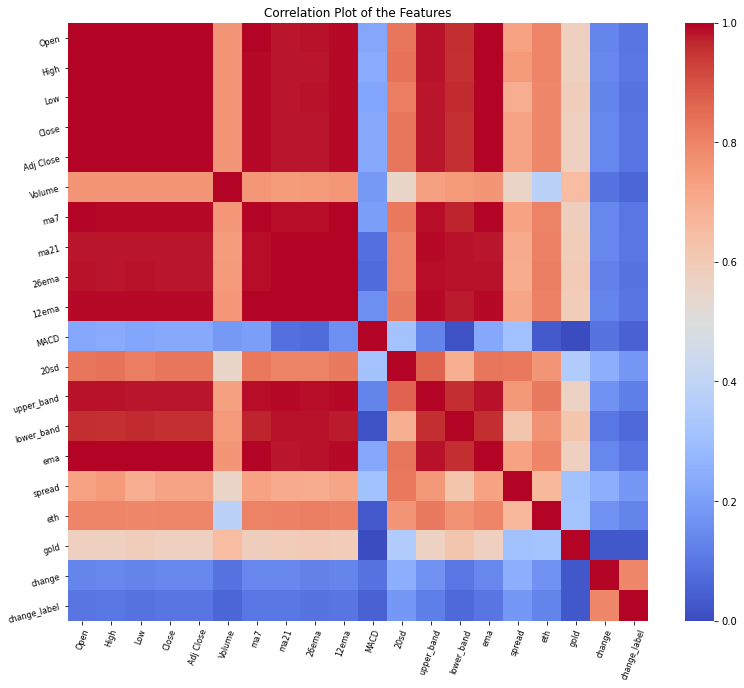

In [ ]:
corr = test_df.corr()
#fig = plt.figure()
#plt.subplot(1, 2, 1)
fig=plt.figure(figsize=(13,11))
g1 = sns.heatmap(corr, cmap='coolwarm', vmin=0, vmax=1)
g1.set_xticklabels(g1.get_xticklabels(), rotation=70, fontsize=8)
g1.set_yticklabels(g1.get_yticklabels(), rotation=15, fontsize=8)
plt.title("Correlation Plot of the Features")
plt.savefig("Corr_Features.png", dpi=200)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


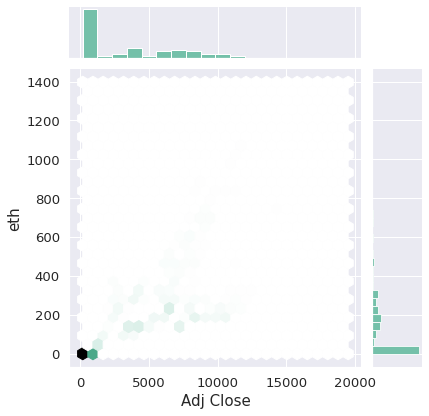

In [ ]:
sns.set(font_scale=1.2)
j=sns.jointplot(test_df['Adj Close'], test_df['eth']
, kind='hex', color="#4CB391")
j.set_axis_labels('Adj Close', 'eth', fontsize=15)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


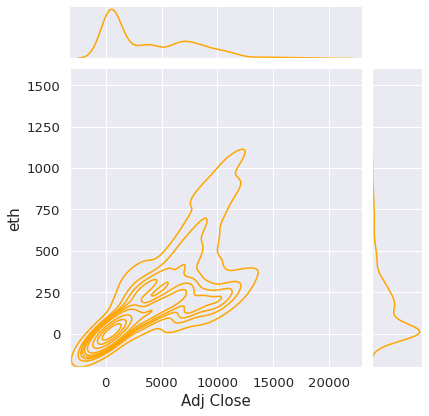

In [ ]:
j2 = sns.jointplot(test_df['Adj Close'], test_df['eth'], kind='kde', color='orange')
j2.set_axis_labels('Adj Close', 'eth', fontsize=15)


In [ ]:
#test_df2=test_df.drop(['change','change_label'])
X_train, X_test, Y_train, Y_test = train_test_split(test_df.drop(['change','change_label'],axis =1 ), test_df.change_label, test_size=0.25, 
                                                    stratify=test_df.change_label, random_state=30)

print ("train feature shape: ", X_train.shape)
print ("test feature shape: ", X_test.shape)

train feature shape:  (1369, 18)
test feature shape:  (457, 18)


In [ ]:
#now PCA.
